# 5. Score-Based Generative Model (Noise Conditional Score Network)

In [1]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim

from utils import *

np.random.seed(0)
torch.manual_seed(0)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
# -------------------------------
# Define Score Network, Loss and Training Functions
# -------------------------------
class ScoreNetwork(nn.Module):
    def __init__(self, input_dim, hidden_dim, sigma_min=0.002, sigma_max=25, num_sigma=40):
        super(ScoreNetwork, self).__init__()
        self.input_dim = input_dim
        self.sigma_min = sigma_min
        self.sigma_max = sigma_max
        self.num_sigma = num_sigma
        # Distribution of sigma values in log-scale and exponentiate to create
        self.sigmas = torch.exp(torch.linspace(np.log(self.sigma_max), np.log(self.sigma_min), self.num_sigma)).to(device)

        # Score network: Given input (data + sigma), predict score (estimate of noise)
        self.net = nn.Sequential(
            nn.Linear(input_dim + 1, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, input_dim)
        )

    def forward(self, x, sigma):
        sigma_feature = sigma.view(-1, 1)
        x_sigma = torch.cat([x, sigma_feature], dim=1)
        score = self.net(x_sigma)
        return score

    def loss_fn(self, x):
        """
        For multiple sigma values, add noise and calculate the MSE between the score predicted by the model and the answer (noise/(sigma^2)).
        """
        total_loss = 0.0
        for sigma in self.sigmas:
            sigma = sigma.to(device)
            sigma_expanded = sigma.expand(x.size(0), 1)
            noise = torch.randn_like(x) * sigma
            x_noisy = x + noise
            score = self.forward(x_noisy, sigma_expanded)
            loss = ((score + noise / (sigma_expanded ** 2)) ** 2).mean()
            total_loss += loss
        return total_loss

    def annealed_langevin_dynamics(self, num_samples, num_steps_each=100, step_size=0.01):
        """
        Generate new samples using Annealed Langevin Dynamics.
        Start with initial x as normal noise and gradually refine depending on sigma value.
        """
        x = torch.randn(num_samples, self.input_dim).to(device)
        self.eval()
        with torch.no_grad():
            for sigma in self.sigmas:
                sigma = sigma.to(device)
                sigma_expanded = sigma.expand(x.size(0), 1)
                for _ in range(num_steps_each):
                    x.requires_grad_(True)
                    score = self.forward(x, sigma_expanded)
                    grad = score
                    x = x + (step_size * grad) + torch.randn_like(x) * np.sqrt(2 * step_size)
                    x = x.detach()
        return x.cpu().numpy()

## 1. Training Stage

In [3]:
def train_score_network(model, dataloader, optimizer, num_epochs):
    model.train()
    for epoch in range(1, num_epochs + 1):
        epoch_loss = 0.0
        for batch in dataloader:
            x = batch[0].to(device)
            optimizer.zero_grad()
            loss = model.loss_fn(x)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item() * x.size(0)
        epoch_loss /= len(dataloader.dataset)
        print(f"Epoch [{epoch}/{num_epochs}], Loss: {epoch_loss:.6f}")

In [4]:
filepath = '../dataset/hts_example.csv'
hidden_dim = 512
learning_rate = 1e-4
num_epochs = 7
batch_size = 512

ground_truth_df, data_tensor, num_categories = load_and_preprocess_data(filepath, device)

dataset = torch.utils.data.TensorDataset(data_tensor)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

input_dim = data_tensor.shape[1]

score_model = ScoreNetwork(input_dim=input_dim, hidden_dim=hidden_dim).to(device)
optimizer = optim.Adam(score_model.parameters(), lr=learning_rate)

train_score_network(score_model, dataloader, optimizer, num_epochs)

Column 'start_type' has 5 unique categories.
Column 'act_num' has 9 unique categories.
Column 'mode_num' has 9 unique categories.
Column 'end_type' has 5 unique categories.
Epoch [1/7], Loss: 651776.446060
Epoch [2/7], Loss: 651666.380720
Epoch [3/7], Loss: 651807.951540
Epoch [4/7], Loss: 651154.493720
Epoch [5/7], Loss: 651602.344100
Epoch [6/7], Loss: 651269.619780
Epoch [7/7], Loss: 651577.451100


## 2. Testing Stage

In [5]:
def generate_score_samples(model, num_samples, num_steps_each=100, step_size=0.01):
    """
    Use a trained Score Network to generate samples using annealed Langevin Dynamics.
    """
    model.eval()
    samples = model.annealed_langevin_dynamics(num_samples, num_steps_each=num_steps_each, step_size=step_size)
    return samples

def map_to_categories(x, columns, num_categories):
    """
    Convert the generated continuous sample x to discrete categories.
    """
    generated_df = pd.DataFrame(x, columns=columns)
    for column in columns:
        max_cat = num_categories[column] - 1
        generated_df[column] = np.floor(generated_df[column]).astype(int)
        generated_df[column] = np.clip(generated_df[column], 0, max_cat)
    return generated_df

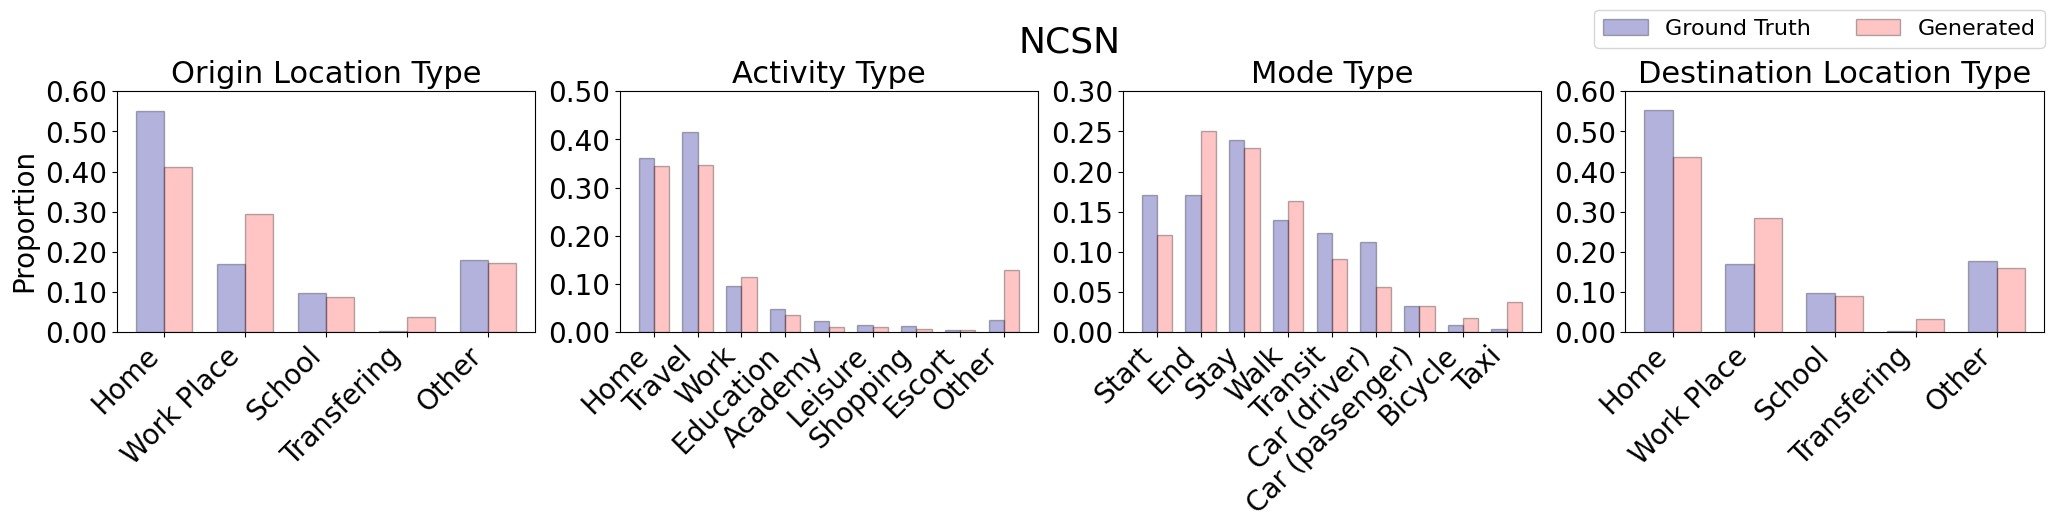

In [6]:
model_name = 'NCSN'
score_model.eval()
num_samples = 3000

columns = ground_truth_df.columns.tolist()
samples = generate_score_samples(score_model, num_samples, num_steps_each=100, step_size=0.01)
generated_df = map_to_categories(samples, columns, num_categories)

xtick_labels_list = [
    ['Home', 'Work Place', 'School', 'Transfering', 'Other'],  # Start Location Type
    ['Home', 'Travel', 'Work', 'Education', 'Academy', 'Leisure', 'Shopping', 'Escort', 'Other'],  # Activity Type
    ['Start', 'End', 'Stay', 'Walk', 'Transit', 'Car (driver)', 'Car (passenger)', 'Bicycle', 'Taxi'],  # Mode Type
    ['Home', 'Work Place', 'School', 'Transfering', 'Other']  # End Location Type
]

visualize_results(model_name, ground_truth_df, generated_df, columns, xtick_labels_list)